In [3]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import numpy as np
import tensorflow as tf

# BGA Filtering

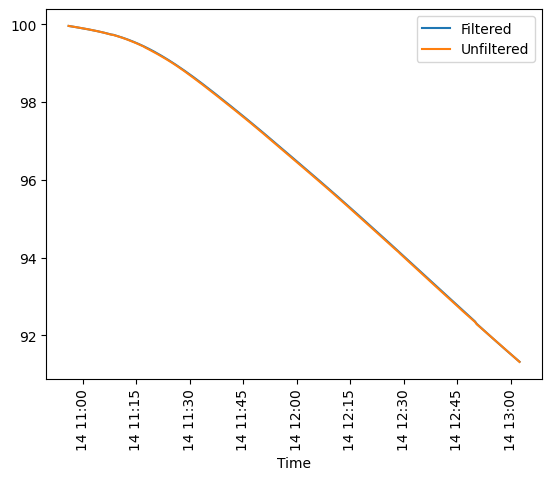

In [183]:
'''
BGA filtering 
'''
path = "G:\\Shared drives\\2023\\QTC\\Manufacturing\\P100 Shop Projects\\Ultrasonic Purity\\April 14 - Outdoor Tests\\20230414_1055_filtered.csv"
data = pd.read_csv(path, delimiter=',', decimal='.')

# Filter the noise from the BGA before fitting
filtered = savgol_filter(data['BGA He Percent (%)'], 50, 3)

# Time strings to datetime objects
data['time'] = pd.to_datetime(data['time'])

# Replace all NaN with the value from row above
data.fillna(method='ffill', inplace=True)
# Drop first row in case it has NaN
log = data.drop(data.index[0])

# Plot the values vs time
plt.plot(data['time'], filtered, label='Filtered')
plt.plot(data['time'], data['BGA He Percent (%)'], label='Unfiltered')
plt.legend()
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.show()


In [181]:
'''
Save the filtered data
'''
data['BGA He Percent (%)'] = filtered
data.to_csv("G:\\Shared drives\\2023\\QTC\\Manufacturing\\P100 Shop Projects\\Ultrasonic Purity\\April 14 - Outdoor Tests\\20230414_1055_filtered.csv")

# Curve Fitting

In [4]:
# Import the csv files
log = pd.read_csv("G:\\Shared drives\\2023\\QTC\\Manufacturing\\P100 Shop Projects\\Ultrasonic Purity\\April 13 - Indoor Test\\20230413_1219_filtered.csv", delimiter=',', decimal='.')
# log = pd.read_csv("C:\\Users\\Quantum\\Desktop\\Data Log Visualization\\BGA Data Logging\\Ultrasonic Clean Data\\Ultrasonic.csv", delimiter=',', decimal='.')

# Time strings to datetime objects
log['time'] = pd.to_datetime(log['time'])

# Replace all NaN with the value from row above
log.fillna(method='ffill', inplace=True)
# Drop first row in case it has NaN
log = log.drop(log.index[0])

# log

In [5]:
# Remove constants before calculating correlation
log.drop(['Air Velocity (m/s)', 'Fixed Distance (m)', 'He Velocity (m/s)'], axis=1, inplace=True)

# Calculate correlation
corr = log.corr()

corr

,Unnamed: 0,BGA He Percent (%),BGA Sound Speed (m/s),Measured Distance (m),Mixture Velocity (m/s),Percent He (%),Pressure (PSIG),Temperature (K)
Unnamed: 0,1.000000,0.986160,0.990375,-0.992079,0.995228,0.989839,0.699046,-0.444908
BGA He Percent (%),0.986160,1.000000,0.996023,-0.998869,0.995992,0.999589,0.578925,-0.546975
BGA Sound Speed (m/s),0.990375,0.996023,1.000000,-0.997718,0.997616,0.997039,0.608196,-0.534797
Measured Distance (m),-0.992079,-0.998869,-0.997718,1.000000,-0.999053,-0.999760,-0.606847,0.528501
Mixture Velocity (m/s),0.995228,0.995992,0.997616,-0.999053,1.000000,0.997860,0.628325,-0.517639
Percent He (%),0.989839,0.999589,0.997039,-0.999760,0.997860,1.000000,0.595945,-0.533181
Pressure (PSIG),0.699046,0.578925,0.608196,-0.606847,0.628325,0.595945,1.000000,0.241863
Temperature (K),-0.444908,-0.546975,-0.534797,0.528501,-0.517639,-0.533181,0.241863,1.000000


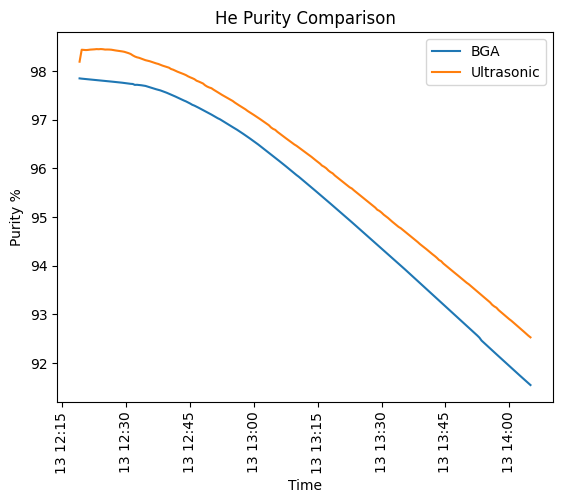

In [6]:
# Plot the values vs time
plt.plot(log['time'], log['BGA He Percent (%)'], label='BGA')
plt.plot(log['time'], log['Percent He (%)'], label='Ultrasonic')
plt.legend()
plt.title('He Purity Comparison')
plt.xlabel('Time')
plt.ylabel('Purity %')
plt.xticks(rotation=90)
plt.show()

avg error: 0.0327189186826736


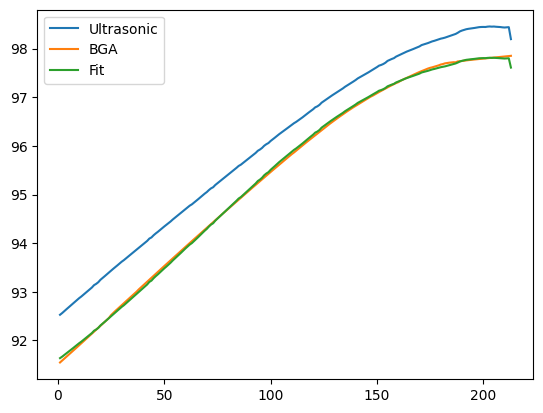

In [44]:
''' 
Curve fitting
'''

# define a model function that describes the relationship between data set A and B
def model_function(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x**2 + e

A = log['Percent He (%)'].copy()
B = log['BGA He Percent (%)'].copy()

diff = A - B

# fit the model function to the data sets A and B using curve fitting
popt, pcov = curve_fit(model_function, A, diff)

# print the best-fit parameters of the model function
# print("a =", popt[0], "b =", popt[1], "c =", popt[2])
# print(pcov)

x = [x for x in range(90, 99, 1)]
y = []
for i in A:
    y.append(model_function(i, *popt))

fit = list(map(lambda x: x - model_function(x, *popt), A))

plt.plot(log.index, A, label='Ultrasonic')
plt.plot(log.index, B, label='BGA')
plt.plot(log.index, fit, label='Fit')

# plt.plot(log.index, diff, label='Difference')
# plt.plot(log.index, y, label='Difference Fit')

# plt.plot(A, B, label='Original')
# plt.plot(A, fit, label='Fit')

plt.legend()

error = B - fit
print(f'avg error: {np.average(abs(error))}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


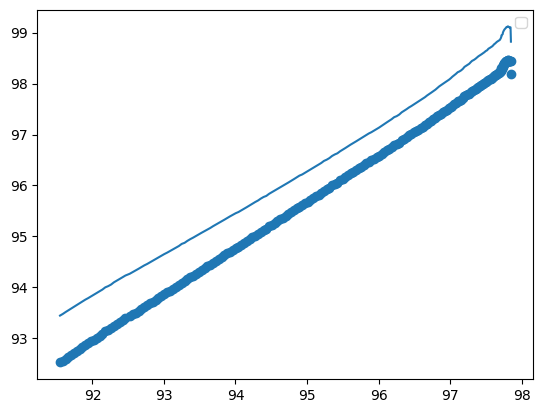

In [7]:
'''
Polynomial Curve Fitting
'''
poly_model = np.poly1d(np.polyfit(log['BGA He Percent (%)'], log['Percent He (%)'], 3))

plt.scatter(log['BGA He Percent (%)'], log['Percent He (%)'])
plt.plot(log['BGA He Percent (%)'], poly_model(log['Percent He (%)']))
plt.legend()

1/1 [==============================] - 0s 136ms/step


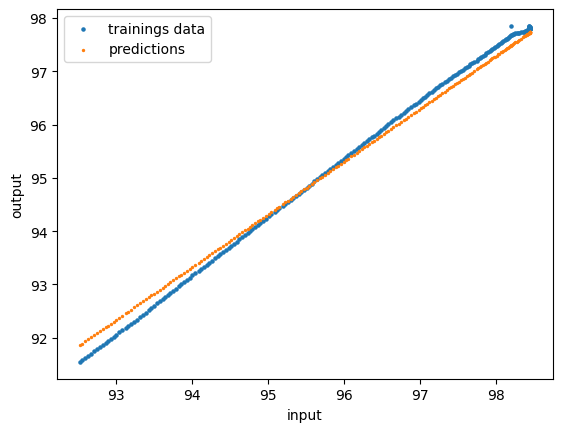

In [15]:
'''
Tensorflow machine learning model
'''

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(16),
    ])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model.fit(log['Percent He (%)'], log['BGA He Percent (%)'], epochs=100, verbose=False)

preds = []
for i in log['Percent He (%)']:
  preds.append(np.average(model.predict([i])))

# fig, ax = plt.subplots()
# fig.set_size_inches(10, 8)
plt.xlabel('input')
plt.ylabel("output")
plt.scatter(log['Percent He (%)'], log['BGA He Percent (%)'], s=5, label="trainings data")
plt.scatter(log['Percent He (%)'], preds, s=2, label="predictions")
plt.legend()

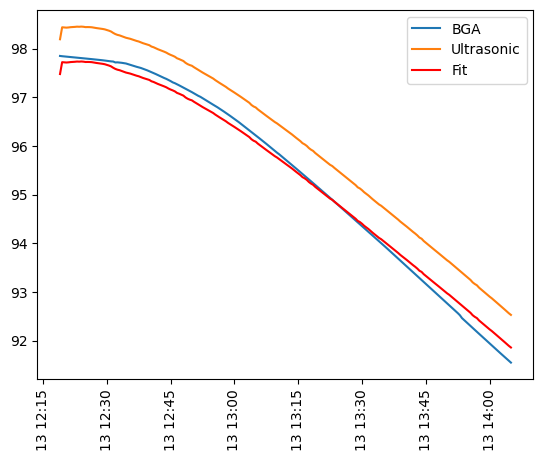

In [16]:
# plot the data sets A and B and the best-fit curve
plt.plot(log['time'], log['BGA He Percent (%)'], label='BGA')
plt.plot(log['time'], log['Percent He (%)'], label='Ultrasonic')

# preds = []
# for i in log['Percent He (%)']:
#   preds.append(model.predict([i])[0][0])

plt.plot(log['time'], preds, 'r-', label='Fit')
plt.xticks(rotation=90)
plt.legend()
plt.show()

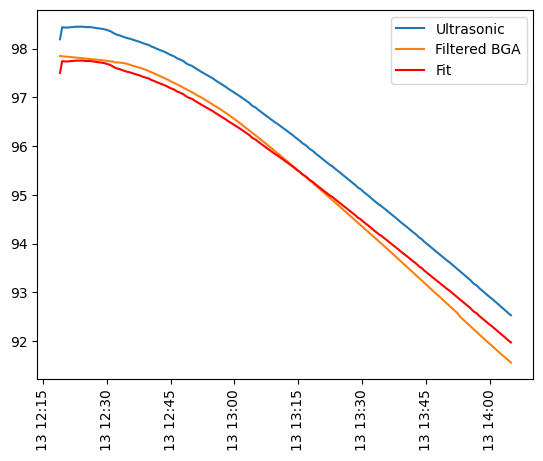

In [150]:
# out = savgol_filter(log['BGA He Percent (%)'], 50, 3)

# plot the data sets A and B and the best-fit curve
plt.plot(log['time'], log['BGA He Percent (%)'], label='BGA')
plt.plot(log['time'], log['Percent He (%)'], label='Ultrasonic')
# plt.plot(log['time'], out, label='Filtered BGA')
plt.plot(log['time'], preds, 'r-', label='Fit')
plt.xticks(rotation=90)

plt.legend()
plt.show()